# Datenauswertung

#### Importiere Bibliotheken

In [2]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

In [4]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.optimize import curve_fit
from pre_processing import *
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
hide_toggle()

## Plotten von simulierten Daten und Fitting

Fitting Funktion: $ P = \alpha*(h-hf)^m $

In [5]:
m_slider = widgets.FloatSlider(min=1,max=2, step=0.1)
a_slider = widgets.FloatSlider(value=0.1, min=0.05,max=1, step=0.05)
noise_P_slider = widgets.FloatSlider(value=0.1, min=0,max=10, step=0.05)
fit_range_slider = widgets.FloatRangeSlider(value=[0.3, 0.95], min=0, max=1, step=0.05)
n_points_slider = widgets.IntSlider(value=100, min=0,max=1000, step=10)
h_f_slider = widgets.IntSlider(value=0, min=0,max=100, step=5)
h_max = 100 #[nm]
#h_f = 0
#noise_std_h = 0.1
#noise_h = np.random.normal(0,noise_std_h, n_points)


def plotfit(m=1.3, alpha=0.1, noise_std_P=0.5, fit_range=[0.3,0.95], n_points=100, h_f=0):
    h = np.linspace(0, h_max, n_points)#[nm]
    noise_P = np.random.normal(0,noise_std_P,n_points)
    P = alpha*(h - h_f)**m+noise_P     #[nN]
    plt.plot(h , P, label='simulated data')
    plt.xlabel('depth [nm]')
    plt.ylabel('Force [nN]')
    popt_log, pcov_log = fitting(h, np.log(P), fit_range, (0.1, 1, 0), fit_func=func_log) 
    popt_exp, pcov_exp = fitting(h, P, fit_range, (0.1,1,0), fit_func=func_exp)
    plt.plot(h, func_exp(h, *popt_log), label = 'log fit')
    plt.plot(h, func_exp(h, *popt_exp), label = 'power law fit')
    plt.legend()
             
    print('Kurvenparameter (alpha, m, hf:)',popt_log)
    print('Abweichung von Modellparametern (log fit):')
    print('\ndelta alpha=', 100*((alpha-popt_log[0])/alpha),'%')
    print('delta m =', 100*((m-popt_log[1])/m),'%')
    print('delta hf =', h_f-popt_log[2],'[nm]')
    print('\nAbweichung von Modellparametern (power law fit):')
    print('\ndelta alpha=', 100*((alpha-popt_exp[0])/alpha),'%')
    print('delta m =', 100*((m-popt_exp[1])/m),'%')
    print('delta hf =', h_f-popt_exp[2],'[nm]')

widgets.interact(plotfit, m=m_slider, alpha=a_slider, noise_std_P=noise_P_slider, fit_range=fit_range_slider,
                 n_points=n_points_slider, h_f=h_f_slider)

hide_toggle()

interactive(children=(FloatSlider(value=1.0, description='m', max=2.0, min=1.0), FloatSlider(value=0.1, descri…

## Überprüfung der Ausrichtung
### Ebenenfitting


Ebenengleichung: $ ax+by+c = z$

Gradient: $\begin{vmatrix} \frac{\partial z}{\partial x} \\
            \frac{\partial z}{\partial x} \end{vmatrix}= (\frac{a}{b}) $


Ebenensteigung: $\arctan({\sqrt{a^2+b^2}})$             [°]

### Mit simulierten Daten

solution: 0.302565 x + 0.604800 y + 4.988354 = z


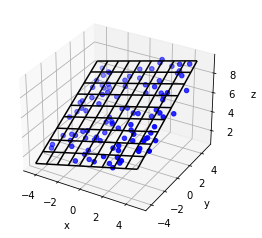

Ebenensteigung: 0.6762601576785291


In [6]:
# These constants are to create random data for the sake of this example
N_POINTS = 100
TARGET_X_SLOPE = 0.3
TARGET_y_SLOPE = 0.6
TARGET_OFFSET  = 5
EXTENTS = 5
NOISE = 0.5



# Create random data.
# In your solution, you would provide your own xs, ys, and zs data.
xs = [np.random.uniform(2*EXTENTS)-EXTENTS for i in range(N_POINTS)]
ys = [np.random.uniform(2*EXTENTS)-EXTENTS for i in range(N_POINTS)]
zs = []
for i in range(N_POINTS):
    zs.append(xs[i]*TARGET_X_SLOPE + \
              ys[i]*TARGET_y_SLOPE + \
              TARGET_OFFSET + np.random.normal(scale=NOISE))
    
# plot raw data
plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(xs, ys, zs, color='b')

# do fit
tmp_A = []
tmp_b = []
for i in range(len(xs)):
    tmp_A.append([xs[i], ys[i], 1])
    tmp_b.append(zs[i])
b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)

# Manual solution
fit = (A.T * A).I * A.T * b
errors = b - A * fit
residual = np.linalg.norm(errors)

# Or use Scipy
# from scipy.linalg import lstsq
# fit, residual, rnk, s = lstsq(A, b)

print("solution: %f x + %f y + %f = z" % (fit[0], fit[1], fit[2]))
#print("errors: \n", errors)
#print("residual:", residual)

# plot plane
xlim = ax.get_xlim()
ylim = ax.get_ylim()
X,Y = np.meshgrid(np.arange(xlim[0], xlim[1]),
                  np.arange(ylim[0], ylim[1]))
Z = np.zeros(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        Z[r,c] = fit[0] * X[r,c] + fit[1] * Y[r,c] + fit[2]
ax.plot_wireframe(X,Y,Z, color='k')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

#print(Z)

#compute slope of plane (gradient)
Z_grad = fit[0:2]
max_grad = np.linalg.norm(Z_grad)
print('Ebenensteigung:', max_grad)
hide_toggle()

### Mit realen Daten aus Array Antastung

Es werden 2 Array Anstastungen, mit jeweils 3x3 Datenpunkten und einem Rasterabstand von 10um aufgenommen. Die erste Messung startet im Ursprung (0,0) und die zweite bei (30,30).
Durch die Datenpunkte wird eine Ebene gefittet und die maximale Steigung bestimmt.


solution: 0.302565 x + 0.604800 y + 4.988354 = z
solution 2: -0.006278 x + -0.000982 y + 3.909630 = z


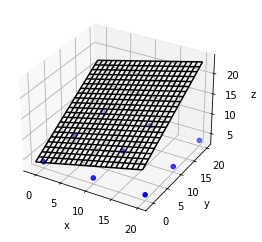

Ebenensteigung in [%]: 67.6260157678529
Ebenensteigung in [°]: 34.068922875335396

Ebenensteigung 2 in [%]: 0.6354707654129035
Ebenensteigung 2 in [°]: 0.36409302770142143


In [7]:
#data from modulus mapping (23.06.22)
xs = [0, 0, 0, 10, 10, 10, 20, 20, 20] #[um]
ys = [0, 10, 20, 20, 10, 0, 0, 10, 20]   #[um]
zs = [3.815748, 3.805186, 3.794780, 3.730393, 3.740052, 3.751712, 3.687332, 3.675042, 3.668683]   #[um]

#data from modulus mapping (24.06.22) start position at (30,30)
#test if second dataset produces same plane gradient
xs_2 = [30, 30, 30, 40, 40, 40, 50, 50, 50] #[um]
ys_2 = [30, 40, 50, 50, 40, 30, 30, 40, 50]   #[um]
zs_2 = [3.691764, 3.681322, 3.672858, 3.610436, 3.618069, 3.629398, 3.566891, 3.556478, 3.545868 ]   #[um]

# plot raw data
plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(xs, ys, zs, color='b')

# do fit
tmp_A = []
tmp_b = []
for i in range(len(xs)):
    tmp_A.append([xs[i], ys[i], 1])
    tmp_b.append(zs[i])
b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)

# do fit on second dataset
tmp_A_2 = []
tmp_b_2 = []
for i in range(len(xs_2)):
    tmp_A_2.append([xs_2[i], ys_2[i], 1])
    tmp_b_2.append(zs_2[i])
b_2 = np.matrix(tmp_b_2).T
A_2 = np.matrix(tmp_A_2)

# Manual solution
fit_2 = (A_2.T * A_2).I * A_2.T * b_2
errors_2 = b_2 - A_2 * fit
residual_2 = np.linalg.norm(errors_2)

# Or use Scipy
#from scipy.linalg import lstsq
#fit, residual, rnk, s = lstsq(A, b)

print("solution: %f x + %f y + %f = z" % (fit[0], fit[1], fit[2]))
#print("errors: \n", errors)
#print("residual:", residual)
print("solution 2: %f x + %f y + %f = z" % (fit_2[0], fit_2[1], fit_2[2]))

# plot plane
xlim = ax.get_xlim()
ylim = ax.get_ylim()
X,Y = np.meshgrid(np.arange(xlim[0], xlim[1]),
                  np.arange(ylim[0], ylim[1]))
Z = np.zeros(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        Z[r,c] = fit[0] * X[r,c] + fit[1] * Y[r,c] + fit[2]
ax.plot_wireframe(X,Y,Z, color='k')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

#print(Z)

#compute slope of plane (gradient)
Z_grad = fit[0:2]
max_grad = np.linalg.norm(Z_grad)
max_deg = np.rad2deg(np.arctan(max_grad))
print('Ebenensteigung in [%]:', max_grad*100)
print('Ebenensteigung in [°]:', max_deg)

Z_grad_2 = fit_2[0:2]
max_grad_2 = np.linalg.norm(Z_grad_2)
max_deg_2 = np.rad2deg(np.arctan(max_grad_2))
print('\nEbenensteigung 2 in [%]:', max_grad_2*100)
print('Ebenensteigung 2 in [°]:', max_deg_2)
hide_toggle()

Man kann erkennen, dass beide Ebenen nahezu den gleichen Gradienten und die gleiche Steigung aufweisen. Der Offsetparameter weist eine größere Abweichung auf, was durch thermischen Drift zu erklären ist, da die Messungen an verschiedenen Tagen durchgeführt wurden. Demnach lässt sich sagen, dass MEMS und Probe eine Winkelabweichung von ~0,37° aufweisen.

## Annäherung der Tastspitze an Sapphir Probe

-snap-in Effekt ist erkennbar

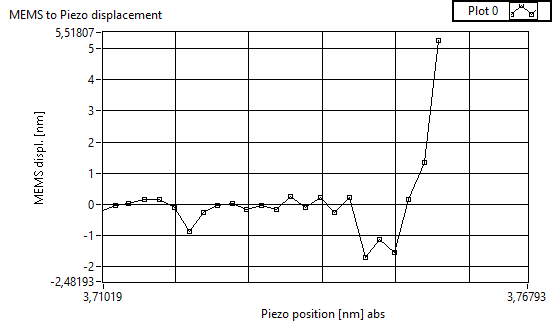

## Dynamik des Piezotisches
Um die dynamischen Eigenschaften des Piezotisches zu untersuchen, wurde die Sprungantwort für verschiedene Sprunghöhen aufgenommen. Aus dem Antwortverhalten kann die Zeitkonstante des Tisches abgeleitet werden, um eine sinnvolle sampling rate für die Messung bestimmen zu können. Die Zeitkonstante wurde bestimmt, indem die Datensätze an die DGL eines Systems 1. Ordnung gefittet wurden. Die Zeitkonstante stellt der Parameter t1 dar.

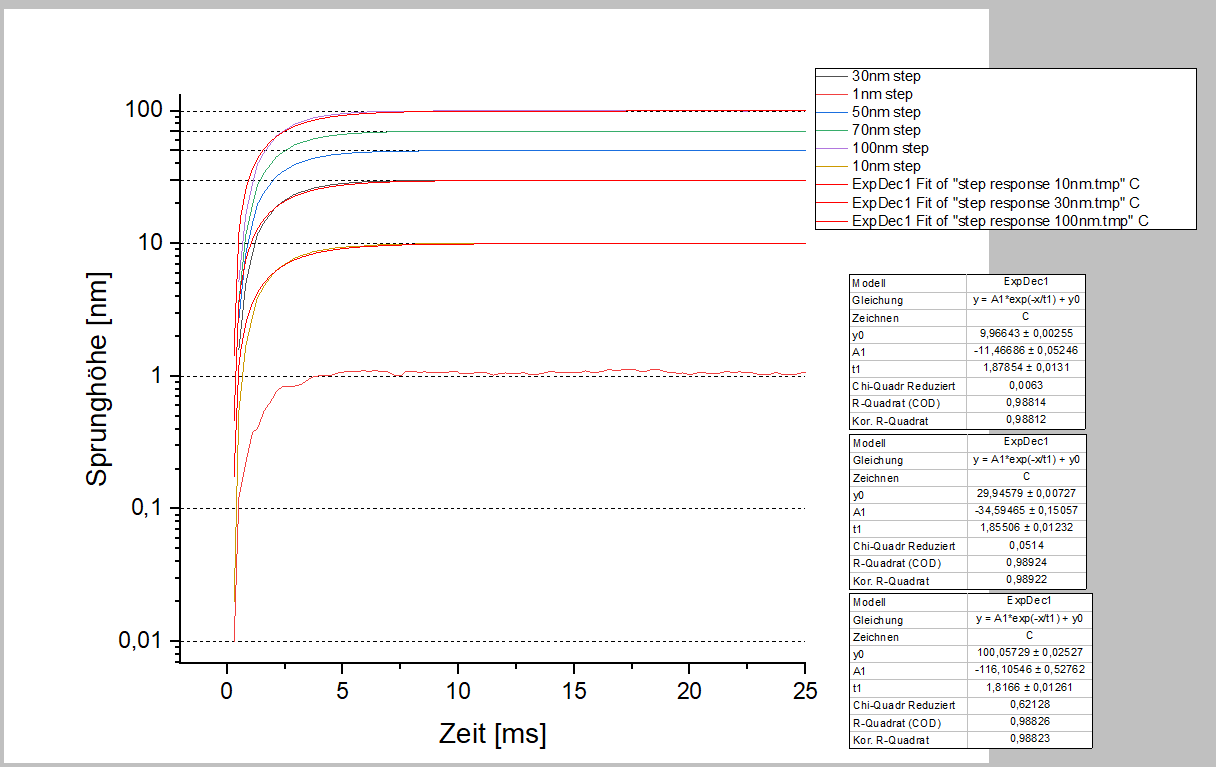

Die Zeitkonstante $\tau$ ist weitestgehend unabhängig von der Sprunghöhe und hat einen Wert von circa 1.8ms. Üblicherweise wird eine Warteperiode von 3 $\tau$ verwendet, was 5.4ms entspricht. Somit kann die maximal mögliche Sampling rate von 90Hz (11ms) genutzt werden.

## Kalibrierung des Kapazität-Verschiebung Koeffizienten
Um S zu bestimmen, fährt der Piezotisch in diesem Fall eine Rampe von 1um, wobei die Kapazität und die Position des Piezotisches in einer Textdatei gespeichert werden. Es wird eine Sapphir Probe genutzt, da durch die sehr hohe Steifigkeit der Probe keine Indentation in das Material erfolgt. Es wird der Koeffizient gesucht, sodass $\delta{z}*S=\delta{C}$. Die Messung liefert:

$\delta{C}=0.43409pf$ und
$\delta{z}=1000nm$.
somit folgt: $S=434.148 \frac{aF}{nm}$

## Testmessung: Partial-unload